# Stories Impressions Analysis

This notebook demonstrates how to compute and compare different interpolation and smoothing methods for Instagram Stories impressions data.

## 1. Load data and compute time since publication

In [34]:
# Load necessary libraries
import pandas as pd
import numpy as np

# Read CSV
# Replace path if necessary
df = pd.read_csv('stories.csv', parse_dates=['data_timestamp', 'published_time'])

# Compute time since publication in minutes
df['time_since_pub'] = (df['data_timestamp'] - df['published_time']).dt.total_seconds() / 60

## 2. Define common 15-minute grid

In [35]:
# Determine maximum time and create 15-minute intervals\ nmax_t = int(df['time_since_pub'].max())
nmax_t = int(df['time_since_pub'].max())
time_grid = np.arange(0, nmax_t + 15, 15)

## 3. Define interpolation and smoothing functions

In [36]:
from scipy.interpolate import PchipInterpolator, interp1d, UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess

def linear_interp(x, y, xi):
    return np.interp(xi, x, y)

def pchip_interp(x, y, xi):
    return PchipInterpolator(x, y)(xi)

def cubic_interp(x, y, xi):
    return interp1d(x, y, kind='cubic', fill_value='extrapolate')(xi)

def smoothing_b_spline(x, y, xi, s_factor=0.1):
    s = len(x) * np.var(y) * s_factor
    return UnivariateSpline(x, y, s=s)(xi)

def loess_interp(x, y, xi, frac=0.3):
    smoothed = lowess(y, x, frac=frac, return_sorted=True)
    return np.interp(xi, smoothed[:, 0], smoothed[:, 1])

## 4. Compute average curves across all posts

In [43]:
methods = {
    'Linear': linear_interp,
    'PCHIP': pchip_interp,
    'Cubic': cubic_interp,
    'Spline': lambda x, y, xi: smoothing_b_spline(x, y, xi, s_factor=0.1),
    'LOESS': lambda x, y, xi: loess_interp(x, y, xi, frac=0.3)
}

def compute_avg_curve(interp_fn, seed=42):
    np.random.seed(seed)
    curves = []
    for _, group in df.groupby('carl_post_id'):
        x = group['time_since_pub'].values
        y = group['impressions'].values
        if len(np.unique(x)) < 2:
            yi = np.full_like(time_grid, fill_value=y[0])
        else:
            order = np.argsort(x)
            yi = interp_fn(x[order], y[order], time_grid)
        curves.append(yi)
    return np.mean(curves, axis=0)

avg_curves = {name: compute_avg_curve(fn) for name, fn in methods.items()}

## 5. Plot comparison

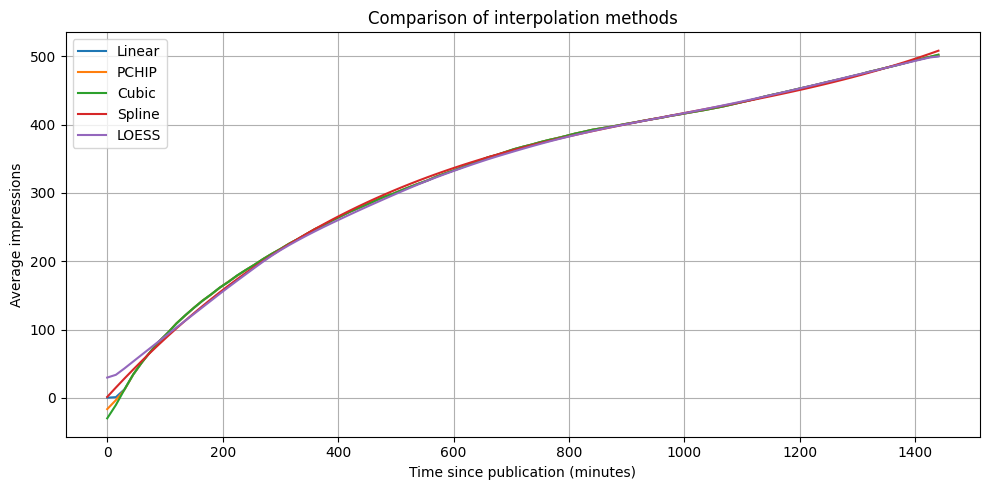

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for name, curve in avg_curves.items():
    plt.plot(time_grid, curve, label=name)
plt.xlabel('Time since publication (minutes)')
plt.ylabel('Average impressions')
plt.title('Comparison of interpolation methods')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Key Insights

- **Linear:** simple but yields sharp transitions.

- **PCHIP:** preserves monotonicity without artifacts.

- **Cubic:** may oscillate outside data support.

- **Spline:** smooths noise; smoothing controlled by s_factor.

- **LOESS:** good for local trends but blurs sharp early growth.

## 7. Quantitative metrics (RMSE)

In [45]:
from sklearn.metrics import mean_squared_error

def compute_rmse(interp_fn, seed=42):
    np.random.seed(seed)
    rmses = []
    for _, group in df.groupby('carl_post_id'):
        x, y = group['time_since_pub'].values, group['impressions'].values
        if len(x) < 3:
            continue
        idx = np.random.choice(len(x), size=int(len(x)*0.2), replace=False)
        x_train = np.delete(x, idx)
        y_train = np.delete(y, idx)
        x_test, y_test = x[idx], y[idx]
        y_pred = interp_fn(np.sort(x_train), y_train[np.argsort(x_train)], x_test)
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return np.mean(rmses)

eval_metrics = {name: compute_rmse(fn) for name, fn in methods.items()}
for name, rmse in eval_metrics.items():
    print(f'{name}: RMSE = {rmse:.2f} impressions')

Linear: RMSE = 4.32 impressions
PCHIP: RMSE = 5.20 impressions
Cubic: RMSE = 13.03 impressions
Spline: RMSE = 14.25 impressions
LOESS: RMSE = 9.75 impressions


## 8. Start and end segment approximation

In [48]:
from scipy.stats import linregress

segments = {'start': (0, 60), 'end': (nmax_t - 60, nmax_t)}
slope_results = {}
for seg, (t0, t1) in segments.items():
    mask = (time_grid >= t0) & (time_grid <= t1)
    for name, curve in avg_curves.items():
        slope, intercept, rvalue, pvalue, stderr = linregress(time_grid[mask], curve[mask])
        slope_results.setdefault(seg, {})[name] = (slope, intercept)
for seg, slopes in slope_results.items():
    print(f"{seg.capitalize()} segment slopes:")
    for name, (slope, intercept) in slopes.items():
        print(f"  {name}: {slope:.4f} impressions/minute, intercept: {intercept:.2f}")

Start segment slopes:
  Linear: 0.9054 impressions/minute, intercept: -7.32
  PCHIP: 1.1607 impressions/minute, intercept: -19.22
  Cubic: 1.3901 impressions/minute, intercept: -30.11
  Spline: 0.8795 impressions/minute, intercept: 1.69
  LOESS: 0.5770 impressions/minute, intercept: 27.26
End segment slopes:
  Linear: 0.2037 impressions/minute, intercept: 208.66
  PCHIP: 0.2078 impressions/minute, intercept: 203.02
  Cubic: 0.2126 impressions/minute, intercept: 196.35
  Spline: 0.2803 impressions/minute, intercept: 104.11
  LOESS: 0.1988 impressions/minute, intercept: 215.07


- Negative or non-zero intercepts at `t=0` arise from extrapolation behavior of smoothing methods (e.g., cubic splines may overshoot). Monotonic PCHIP anchors exactly at first data point.

- End-segment slopes quantify how quickly impressions are still growing near story expiration.

This completes the analysis with both visual and numerical evaluation.